In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import multiprocessing as mp
from itertools import repeat
%matplotlib inline

In [21]:
train_path = r'C:\Users\frenc\Documents\dottorato\ising\train'
#test_path = '../../data/Ising/test/'
valid_path = r'C:\Users\frenc\Documents\dottorato\ising\validation'

In [22]:
def createArray(L):
    mat = np.random.randint(0,2,size=(L,L), dtype=int)
    mat[mat==0] = -1 
    # Could also generate a uniform state, which is better for the Wolff algorithm
    #mat = np.ones(shape=(L,L), dtype=int)
    return mat

In [23]:
import numpy as np

def iterate(mat, T, calcE=False):
    """
    Metropolis algorithm for a square lattice
    
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    
    Returns:
        float or None: Average energy per spin if calcE is True, None otherwise
    """
    L, _ = mat.shape
    
    order1 = np.arange(L)
    order2 = np.arange(L)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_new = -spin_current  # Simplified spin flip
            
            # Calculate neighbor sum once and reuse
            neighbor_sum = (mat[(i+1)%L,j] + mat[(i-1)%L,j] + 
                          mat[i,(j+1)%L] + mat[i,(j-1)%L])
            
            # Calculate energy difference
            E_current = -spin_current * neighbor_sum
            E_new = -spin_new * neighbor_sum
            E_diff = E_new - E_current
            
            # Metropolis acceptance criterion
            if E_diff <= 0 or np.random.random() <= np.exp(-E_diff/T):
                mat[i,j] = spin_new
    
    if calcE:
        avgE = 0.0
        for i in range(L):  # Changed to use range instead of order1
            for j in range(L):
                spin_final = mat[i,j]
                # Recalculate neighbor sum for final configuration
                neighbor_sum = (mat[(i+1)%L,j] + mat[(i-1)%L,j] + 
                              mat[i,(j+1)%L] + mat[i,(j-1)%L])
                E_final = -spin_final * neighbor_sum
                avgE += E_final
        
        avgE /= (L * L)  # More readable than L**2
        return avgE
    
    return None  # Explicit return when calcE is False

In [24]:
import numpy as np

def flip_cluster(mat, cluster):
    """Flip all spins in a cluster for the Wolff algorithm.
    
    Args:
        mat (np.ndarray): 2D numpy array containing the current spin configuration
        cluster (list): List of tuples (i,j) representing positions of spins to be flipped
    """
    for i, j in cluster:
        mat[i, j] *= -1

def iterate_wolff(mat, T, calc_e=False):
    """Perform one iteration of the Wolff algorithm for a 2D Ising model on a square lattice.
    
    Args:
        mat (np.ndarray): 2D numpy array containing the current spin configuration
        T (float): Temperature for the simulation (in units of J/kB)
        calc_e (bool, optional): Flag to calculate and return the average energy per spin. 
            Defaults to False.
    
    Returns:
        float or None: Average energy per spin if calc_e is True, None otherwise
    
    Notes:
        - Periodic boundary conditions are used
        - The coupling constant J is assumed to be 1
        - The Boltzmann constant kB is assumed to be 1
    """
    L = mat.shape[0]
    if mat.shape != (L, L):
        raise ValueError("Input matrix must be square")
    
    # Keep track of which spins have been considered for the cluster
    tracker = np.zeros((L, L), dtype=bool)
    
    # Randomly select starting point
    i, j = np.random.randint(0, L, size=2)
    spin = mat[i, j]
    
    # Initialize cluster with starting point
    stack = [(i, j)]
    tracker[i, j] = True
    cluster = [(i, j)]
    
    # Probability of adding aligned spins to cluster
    p_add = 1.0 - np.exp(-2.0 / T)
    
    # Grow cluster
    while stack:
        i, j = stack.pop()
        # Check all nearest neighbors
        for ni, nj in [(i, (j+1)%L), (i, (j-1)%L), ((i+1)%L, j), ((i-1)%L, j)]:
            if mat[ni, nj] == spin and not tracker[ni, nj] and np.random.random() < p_add:
                cluster.append((ni, nj))
                stack.append((ni, nj))
                tracker[ni, nj] = True
    
    # Flip the cluster
    flip_cluster(mat, cluster)
    
    if calc_e:
        # Calculate average energy per spin
        energy = 0.0
        for i in range(L):
            for j in range(L):
                spin = mat[i, j]
                neighbors_sum = (mat[(i+1)%L, j] + mat[(i-1)%L, j] + 
                               mat[i, (j+1)%L] + mat[i, (j-1)%L])
                energy -= spin * neighbors_sum
        
        return energy / (2.0 * L * L)  # Factor of 2 corrects for double counting
    
    return None

In [25]:
import numpy as np

def calc_correlation(mat, dist):
    """Calculate the spin-spin truncated correlation function for spins separated by a specified distance.
    
    This function computes the two-point correlation function for a 2D Ising model,
    averaged over all pairs of spins separated by the given distance in both horizontal
    and vertical directions.
    
    Args:
        mat (np.ndarray): 2D numpy array containing the current spin configuration
        dist (int): Distance value for the correlation function
        
    Returns:
        tuple: (distance, correlation_function_value)
        
    Notes:
        - Uses periodic boundary conditions
        - Includes both horizontal and vertical separations
        - Returns the connected correlation function: <s_i * s_j> - <s_i><s_j>
    """
    L = mat.shape[0]
    if mat.shape != (L, L):
        raise ValueError("Input matrix must be square")
    if dist >= L:
        raise ValueError("Distance must be less than system size")
    
    # Calculate spin products for pairs separated by distance
    products = 0.0
    spin_sum = 0.0
    
    for i in range(L):
        for j in range(L):
            # Reference spin
            spin_i = mat[i, j]
            spin_sum += spin_i
            
            # Get spins at distance 'dist' in all four directions
            spins_at_dist = (
                mat[i, (j + dist) % L],  # right
                mat[i, (j - dist) % L],  # left
                mat[(i + dist) % L, j],  # down
                mat[(i - dist) % L, j]   # up
            )
            
            # Sum the products with all spins at distance 'dist'
            products += spin_i * sum(spins_at_dist)
    
    # Normalize the sums
    n_pairs = 4 * L * L  # Total number of pairs counted
    products /= n_pairs
    avg_spin = spin_sum / (L * L)
    
    # Calculate connected correlation function
    correlation = products - avg_spin * avg_spin
    
    return dist, correlation

def calc_correlation_length(corrs, distances=None):
    """Calculate the correlation length from correlation function values.
    
    Fits the correlation function to an exponential decay and extracts
    the correlation length from the fitted slope.
    
    Args:
        corrs (np.ndarray): Array of correlation function values
        distances (np.ndarray, optional): Array of distances corresponding to correlation values.
            If None, assumes distances start at 1 and increment by 1.
    
    Returns:
        float: Correlation length
        
    Notes:
        - Fits log(correlation) vs. distance to extract correlation length
        - Correlation length is negative inverse of the fitted slope
        - Assumes exponential decay of correlations
    """
    if distances is None:
        distances = np.arange(1, len(corrs) + 1, dtype=float)
    
    if len(corrs) < 2:
        raise ValueError("Need at least two points to calculate correlation length")
    
    # Take log of absolute value of correlations to handle possible negative values
    log_corrs = np.log(np.abs(corrs))
    
    # Perform linear fit to log(correlations)
    slope, _ = np.polyfit(distances, log_corrs, 1)
    
    # Correlation length is negative inverse of slope
    correlation_length = -1.0 / slope
    
    return correlation_length

In [26]:
def simulate(mat,T,steps):
    #MC simulation for a square lattice, using the Wolff algorithm
    for _ in range(steps):
        iterate_wolff(mat,T)

In [27]:
def generateSamples(T,L,steps,samples,dirPath):
    # Generate, label, and save configurations for a square lattice
    """
    Parameters:
        T: Temperature
        L: Linear lattice size
        steps: Number of simulation steps
        sample: Number of configuration steps
        dirPath: save location
    """
    for i in range(1,samples+1):
        mat = createArray(L)
        simulate(mat,T,steps)
        
        if T<2.27: # For a square lattice, the critical T is ~2.27
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,category)
        os.makedirs(path, exist_ok=True)
        np.save(os.path.join(path,f"{category}_{T:.2f}_{i}_"),mat)

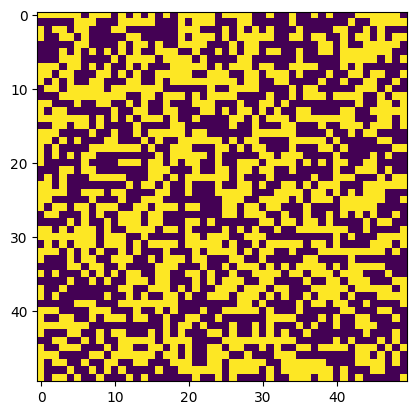

In [28]:
# Initial configuration of 50x50 Ising lattice
mat=createArray(50)
plt.imshow(mat)

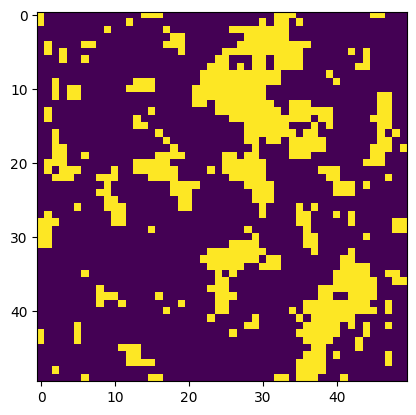

In [29]:
simulate(mat,2.3,3000)
plt.imshow(mat)

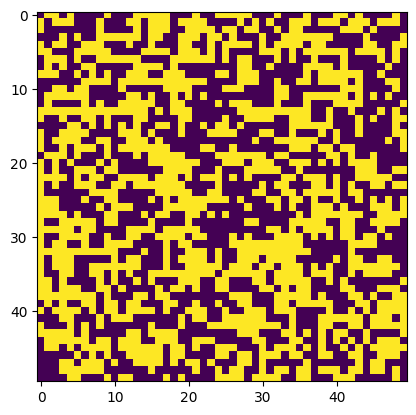

In [30]:
# High temperature simulation of 50x50 Ising lattice
mat=createArray(50)
simulate(mat,9.3,3000)
plt.imshow(mat)

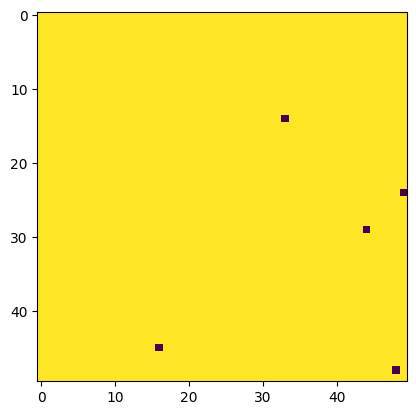

In [31]:
mat=createArray(50)
simulate(mat,1.2,30)
plt.imshow(mat)

In [32]:
steps=20000
mat_lowT=createArray(20)
mat_critT=createArray(20)
mat_highT=createArray(20)

avgE_lowT = np.zeros(steps)
avgE_critT = np.zeros(steps)
avgE_highT = np.zeros(steps)

for step in tqdm(range(steps)):
    
    avgE_lowT[step] = iterate_wolff(mat_lowT,1.8,True)
    avgE_critT[step] = iterate_wolff(mat_critT,2.3,True)
    avgE_highT[step] = iterate_wolff(mat_highT,3.1,True)
    

100%|██████████| 20000/20000 [00:51<00:00, 389.65it/s]


Text(0, 0.5, 'Avg particle energy')

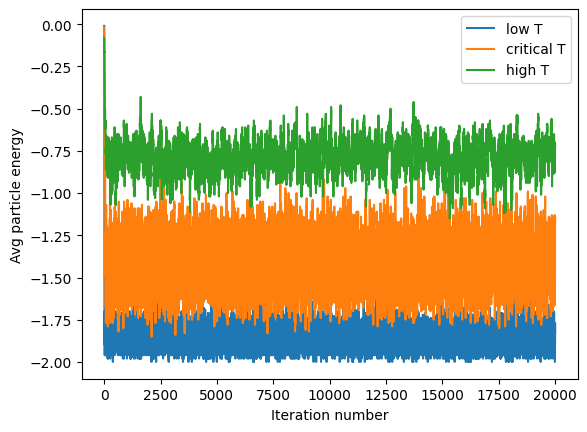

In [33]:
plt.plot(avgE_lowT, label = "low T")
plt.plot(avgE_critT,label = "critical T")
plt.plot(avgE_highT,label = "high T")
plt.legend(loc="upper right")
plt.xlabel("Iteration number")
plt.ylabel("Avg particle energy")

In [34]:
Temps = np.concatenate((np.arange(1.5,3.2,0.1),np.arange(1.75,3.05,0.1)))

Temps

array([1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.  , 2.1 , 2.2 , 2.3 , 2.4 , 2.5 ,
       2.6 , 2.7 , 2.8 , 2.9 , 3.  , 3.1 , 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [35]:
import os
import numpy as np
from tqdm import tqdm

def generateSamples(T, L, steps, samples, dirPath):
    """
    Generate, label, and save configurations for a square lattice.

    Parameters:
        T (float): Temperature.
        L (int): Linear lattice size.
        steps (int): Number of simulation steps.
        samples (int): Number of configuration steps.
        dirPath (str): Save location.
    """
    for i in tqdm(range(1, samples + 1), desc=f"Generating samples at T={T:.2f}",dynamic_ncols=True, position=1):
        mat = createArray(L)
        simulate(mat, T, steps)

        category = "low" if T < 2.27 else "high"
        path = os.path.join(dirPath, category)
        os.makedirs(path, exist_ok=True)

        np.save(os.path.join(path, f"{category}_{T:.2f}_{i}.npy"), mat)


In [36]:
import numpy as np
import os
from tqdm import tqdm

# Example temperature range
samples = 500
L = 20
steps = 1000
train_path = "train"  # Set the actual path

# Sequential processing with tqdm
for T in tqdm(Temps, desc="Processing Temperatures", position = 0):
    generateSamples(T, L, steps, samples, train_path)

Processing Temperatures: 100%|██████████| 30/30 [3:07:20<00:00, 374.67s/it]


In [37]:
import numpy as np
import os
from tqdm import tqdm

# Example temperature range
samples = 100
L = 20
steps = 1000
train_path = "validation"  # Set the actual path

# Sequential processing with tqdm
for T in tqdm(Temps, desc="Processing Temperatures", position = 0):
    generateSamples(T, L, steps, samples, train_path)

Processing Temperatures: 100%|██████████| 30/30 [28:57<00:00, 57.91s/it]
